# Foundations Of AIML
## Session 11
### Experiment 2.1: Extracting features using pre-trained CNN

Deep neural networks are super hungry for training data. Training data is expensive. Labelling or annotating data is a painful task. Fortunately, *for most tasks* we don't have to label/buy/crawl millions of data points to train the model. It is common to use public data from the similar domain (image, audio, text). There are thousands of researchers/students who use this data in their works. We could make use of their effort and resources spent on training the model on gigantic datasets for our task of interest. 

In this experiment we want to perform face recognition of 16 Indian celebrities from IMFDB dataset.
We simply pick the model (lightCNN) trained for face recognition on million of images and thousands of individuals. We use the feature coming out of this model to train a new classifier to identify 16 Indian celebrities.

In [0]:
# Importing pytorch packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
# Importing config.py file
import config as cf
from utils import *
from light_cnn import network_9layers
from data_loader import *
## Importing python packages
import cv2
import os
import sys
import time
import datetime
import numpy as np
import math
import matplotlib.pyplot as plt

We will use a custom data loader to feed the images to the network (see data_loader.py). Light CNN expects grayscale 128x128 image. We do this processing in the data loader. Notice below that shuffle is True for training and False for validation. What could be the reason???

In [2]:
img_root = cf.data_dir+'IMFDB_final/'

train_list_file = cf.data_dir+'IMFDB_train.txt'   #### 5000 images for training
val_list_file = cf.data_dir+'IMFDB_test.txt'      #### 1095 images for validation


train_image_list = [line.rstrip('\n') for line in open(train_list_file)]
val_image_list = [line.rstrip('\n') for line in open(val_list_file)]

print len(train_image_list), len(val_image_list)

trainloader = torch.utils.data.DataLoader(custom_data_loader(img_root = img_root, image_list = train_list_file, crop=False,
                                                             resize = True, resize_shape=[128,128]), 
                                           batch_size=32, num_workers=16, shuffle = True, pin_memory=True)

testloader = torch.utils.data.DataLoader(custom_data_loader(img_root = img_root, image_list = val_list_file, crop=False, mirror=False, 
                                                           resize = True, resize_shape=[128,128]), 
                                           batch_size=10, num_workers=5, shuffle = False, pin_memory=True)


classes = ['AamairKhan', 'Rimisen', 'Kajol', 'KareenaKapoor','RishiKapoor', 'AmrishPuri', 'AnilKapoor', 'AnupamKher', 'BomanIrani', 'HrithikRoshan', 'KajalAgarwal', 'KatrinaKaif', 'Madhavan', 'MadhuriDixit', 'Umashri', 'Trisha']

IOError: ignored

#### example images of 16 celebrities selected from IMFDB.

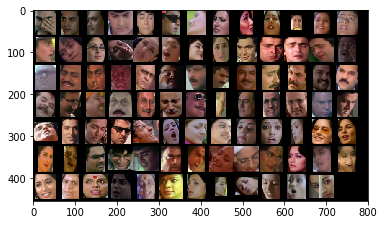

In [0]:
plt.imshow(cv2.imread(cf.data_dir+'IMFDB-16.png')[:,:,::-1])
plt.show()

In [0]:
# Checking for GPU instance
use_cuda = torch.cuda.is_available()
#Intilizaing the accuracy value as zero
best_acc = 0
num_classes = 16  ### 16 celebrities

In [0]:
feature_net = network_9layers()   ### creates an object of this network architecture
from collections import OrderedDict
new_state_dict = OrderedDict()
state_dict = torch.load(cf.data_dir+'light_cnn/LightCNN_9Layers_checkpoint.pth.tar')['state_dict']    ### load the learned lightCNN weights
for k, v in state_dict.items():
    name = k[7:] 
    new_state_dict[name] = v

feature_net.load_state_dict(new_state_dict)     #### copy these weights into the model


### Light CNN architecture is defined in light_cnn.py. We intend to use the output of FC1 layer as 256-dimensional features to train the classifier.
### we will use a 3 layers MLP as classifier. Notice the first layer has input channel equals to output feature dimension of Light CNN.
classifier = nn.Sequential(nn.Linear(256, 64), nn.BatchNorm1d(64), nn.ReLU(),
                           nn.Linear(64, 32), nn.BatchNorm1d(32), nn.ReLU(),
                           nn.Linear(32, num_classes))

if use_cuda:
    feature_net.cuda()
    classifier.cuda()

feature_net.eval()  ### since we only use the pre-trained model for feature extraction, we set it to eval mode i.e., we don't intend to update its weights.

network_9layers(
  (features): Sequential(
    (0): mfm(
      (filter): Conv2d (1, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (2): group(
      (conv_a): mfm(
        (filter): Conv2d (48, 96, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (filter): Conv2d (48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (4): group(
      (conv_a): mfm(
        (filter): Conv2d (96, 192, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (filter): Conv2d (96, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (6): group(
      (conv_a): mfm(
        (filter): Conv2d (192, 384, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (filter): Conv2d (192, 256, kern

In [0]:
### Intiliazing the loss
criterion = nn.CrossEntropyLoss()

In [0]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    classifier.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        features = feature_net.get_features(inputs).detach()         #### get_features() returns the 256-dimensional feature
        
        
        outputs = classifier(features)                             ### use 256-dim feature as input to the classifier.
        size_ = outputs.size()
        outputs_ = outputs.view(size_[0], num_classes)
        loss = criterion(outputs_, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.data[0]
        _, predicted = torch.max(outputs_.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        
        if batch_idx%30 == 0 or batch_idx == len(trainloader)-1:
            progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        
    train_loss_file.write('%d %.3f %.3f\n' %(epoch, train_loss/len(trainloader), 100.*correct/total))



In [0]:
def test(epoch):
    global best_acc
    classifier.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        features = feature_net.get_features(inputs).detach()
        
        outputs = classifier(features)
        size_ = outputs.size()
        outputs_ = outputs.view(size_[0], num_classes)
        loss = criterion(outputs_, targets)

        test_loss += loss.data[0]
        _, predicted = torch.max(outputs_.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        
        if batch_idx%30 == 0 or batch_idx == len(testloader)-1:
            progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
        
    print 'val_loss: ',  test_loss/len(testloader), 'accuracy: ', 100.0*correct/total
    val_loss_file.write('%d %.3f %.3f\n' %(epoch,  test_loss/len(testloader), 100.*correct/total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': classifier,
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir(cf.data_dir+'checkpoint'):
            os.mkdir(cf.data_dir+'checkpoint')
        torch.save(state, cf.data_dir+'checkpoint/checkpoint_ckpt.t7')
        best_acc = acc
    
    return test_loss/len(testloader)

In [0]:
experiment = 'lightnet_features_IMFDB'
train_loss_file = open(cf.data_dir+experiment+"train_loss.txt", "w", 0)
val_loss_file = open(cf.data_dir+experiment+"val_loss.txt", "w", 0)

In [0]:
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)   #### dynamic LR scheduler
for epoch in range(0, 30):
    train(epoch)
    test_loss = test(epoch)
    scheduler.step(test_loss)
    
train_loss_file.close()
val_loss_file.close()


Epoch: 0
 [==================================>] | Loss: 2.570 | Acc: 21.480% (1074/5000) 157/157 
 [==================================>] | Loss: 2.368 | Acc: 29.772% (326/1095)  110/110 
val_loss:  2.36826351881 accuracy:  29.7716894977
Saving..

Epoch: 1
 [==================================>] | Loss: 2.135 | Acc: 36.460% (1823/5000) 157/157 
 [==================================>] | Loss: 2.077 | Acc: 34.064% (373/1095)  110/110 
val_loss:  2.07663096731 accuracy:  34.0639269406
Saving..

Epoch: 2
 [==================================>] | Loss: 1.811 | Acc: 44.420% (2221/5000) 157/157 
 [==================================>] | Loss: 1.841 | Acc: 40.274% (441/1095)  110/110 
val_loss:  1.84131496061 accuracy:  40.2739726027
Saving..

Epoch: 3
 [==================================>] | Loss: 1.601 | Acc: 50.360% (2518/5000) 157/157 
 [==================================>] | Loss: 1.697 | Acc: 44.566% (488/1095)  110/110 
val_loss:  1.69714085514 accuracy:  44.5662100457
Saving..

Epoch: 4
 [

30 30


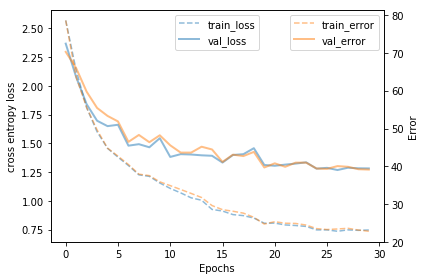

In [0]:
training_curves(cf.data_dir+experiment)

Lets evaluate the classifier and see the mistakes it made. Confusion matrix gives the quantitative measure of the mistakes. The diagonal elements shows the correct classification and others shows the mistake. We want the diagonal elements of this matrix to be close to 1.

In [0]:
### After training we load the model that performed the best on validation data (avoid picking overfitted model)
classifier = torch.load(cf.data_dir+'/checkpoint/checkpoint_ckpt.t7')['net'].eval()

In [0]:
def eval():
    
    classifier.eval()
    testloader = torch.utils.data.DataLoader(custom_data_loader(img_root = img_root, image_list = val_list_file, crop=False, mirror=False, 
                                                           resize = True, resize_shape=[128,128]), 
                                           batch_size=1, num_workers=1, shuffle = False, pin_memory=True)
    correct = 0
    total = 0
    conf_mat = np.zeros((num_classes, num_classes))
    total_ = np.zeros((num_classes))
    wrong_predictions = []
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        features = feature_net.get_features(inputs).detach()
        
        outputs = classifier(features)
        size_ = outputs.size()
        outputs_ = outputs.view(size_[0], num_classes)
        _, predicted = torch.max(outputs_.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        prediction = predicted.cpu().numpy()[0]
        targets = targets.data.cpu().numpy()[0]
        total_[targets] +=1
        conf_mat[predicted, targets] +=1
        
        if prediction != targets:
            wrong_predictions += [[inputs, prediction, targets]]
        
    for k in range(num_classes):
        conf_mat[:,k] /= total_[k]
    return conf_mat, 100.*correct/total, wrong_predictions
    

In [0]:
conf, acc, wrong_predictions = eval()
print 'Accuracy:', acc, '%'

Accuracy: 60.8219178082 %


This means the feature are indeed useful. 60% classification accuracy for 16 classes. Lets see the confusion matrix. Notice 'jet' colormap is used to enhance contrast. dark blue is 0, green/yellow is somewhere in between, and dark red is 1 (Blue-Green-Yellow-Orange-Red order).

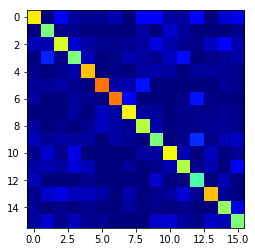

In [0]:
plt.imshow(conf, cmap='jet', vmin=0, vmax = 1)
plt.show()

Trisha confused with RishiKapoor


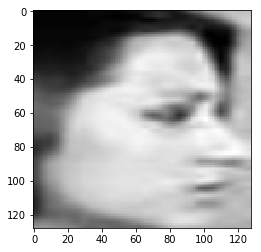

BomanIrani confused with AamairKhan


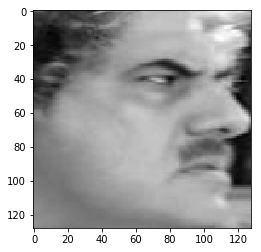

Trisha confused with KatrinaKaif


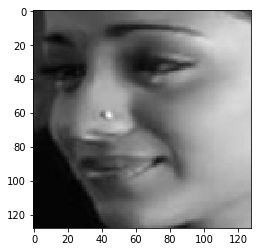

Umashri confused with KareenaKapoor


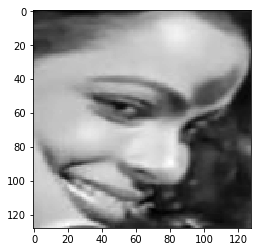

AnupamKher confused with AmrishPuri


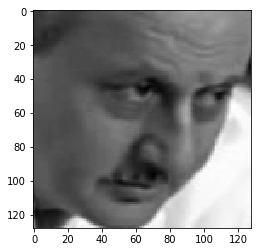

Rimisen confused with Trisha


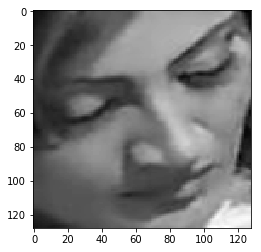

Madhavan confused with HrithikRoshan


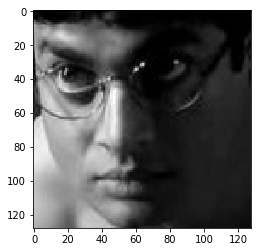

Kajol confused with KajalAgarwal


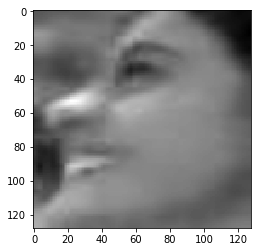

RishiKapoor confused with KatrinaKaif


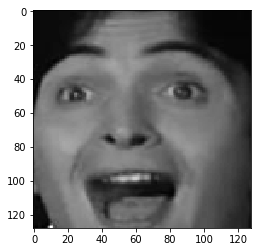

Kajol confused with MadhuriDixit


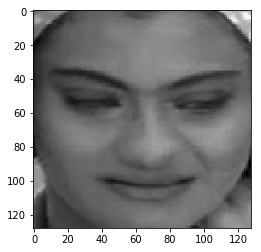

RishiKapoor confused with Umashri


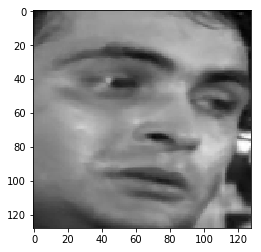

HrithikRoshan confused with RishiKapoor


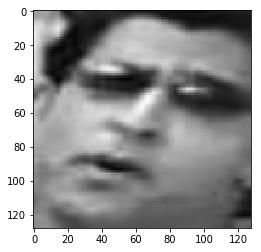

Trisha confused with Umashri


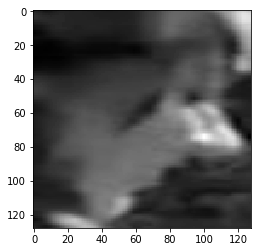

KatrinaKaif confused with KareenaKapoor


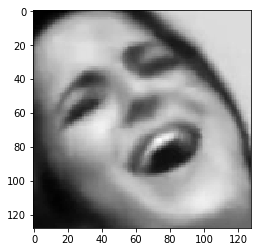

Umashri confused with RishiKapoor


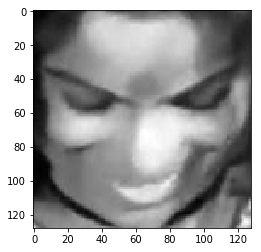

KatrinaKaif confused with Umashri


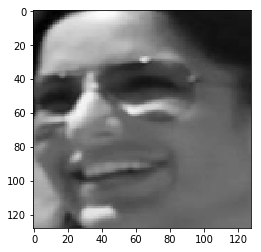

KatrinaKaif confused with KareenaKapoor


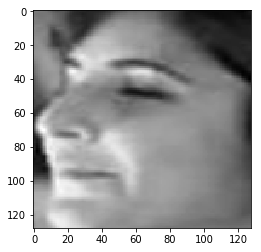

Trisha confused with AamairKhan


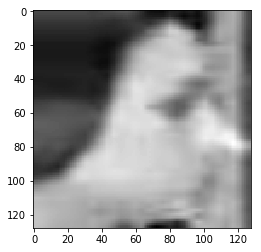

KareenaKapoor confused with KajalAgarwal


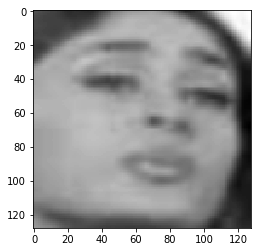

RishiKapoor confused with KareenaKapoor


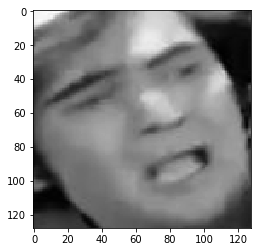

AnilKapoor confused with AamairKhan


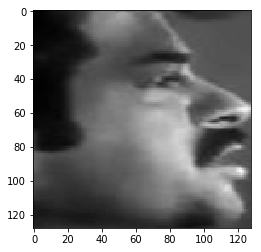

AnilKapoor confused with AnupamKher


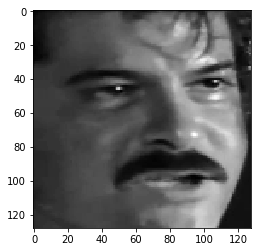

AnilKapoor confused with AmrishPuri


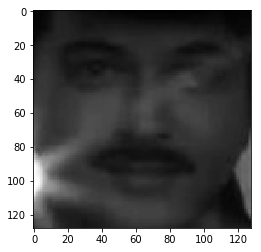

RishiKapoor confused with AamairKhan


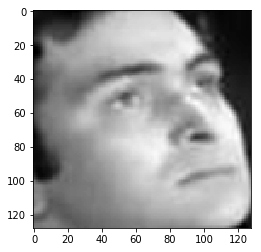

MadhuriDixit confused with Trisha


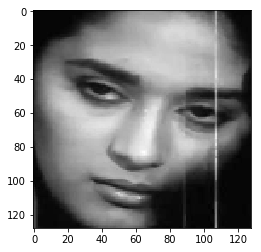

MadhuriDixit confused with Kajol


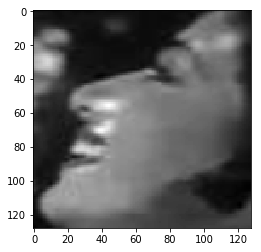

Umashri confused with Trisha


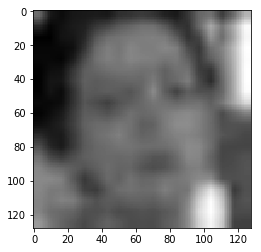

KajalAgarwal confused with Rimisen


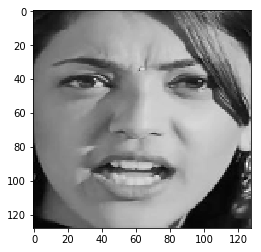

KajalAgarwal confused with KareenaKapoor


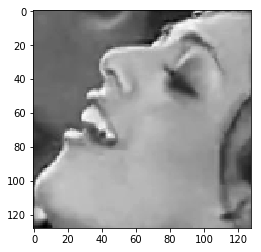

Trisha confused with KatrinaKaif


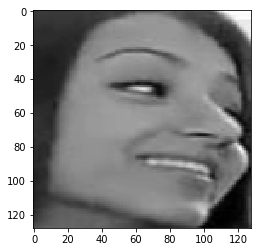

AmrishPuri confused with Kajol


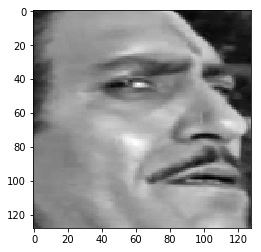

Rimisen confused with MadhuriDixit


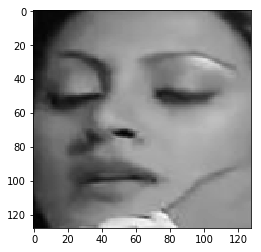

Kajol confused with AmrishPuri


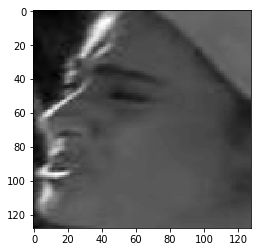

AmrishPuri confused with AnupamKher


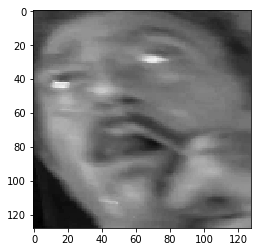

Rimisen confused with HrithikRoshan


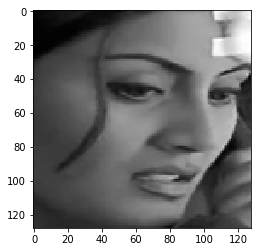

MadhuriDixit confused with KajalAgarwal


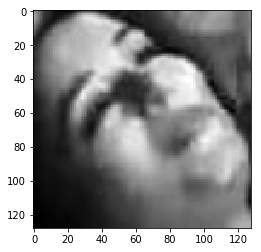

Umashri confused with BomanIrani


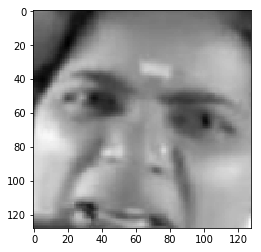

KatrinaKaif confused with MadhuriDixit


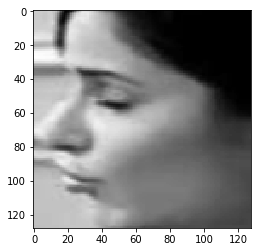

AamairKhan confused with Kajol


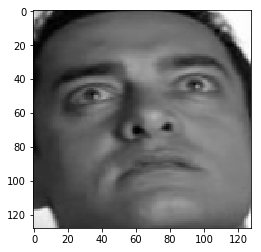

Madhavan confused with AnilKapoor


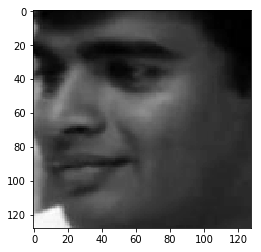

Trisha confused with KareenaKapoor


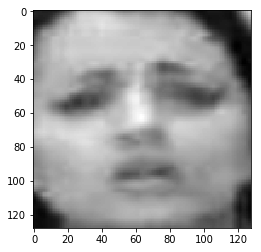

Kajol confused with KareenaKapoor


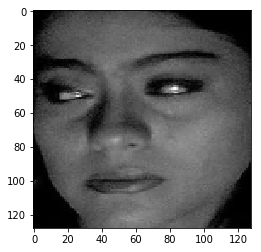

Rimisen confused with Trisha


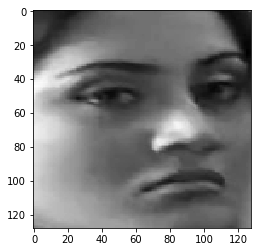

In [0]:
for w in wrong_predictions[::10]:
    print classes[w[2]], 'confused with', classes[w[1]]
    plt.imshow(w[0][0][0].data.cpu().numpy(), cmap='gray')
    plt.show()